In [69]:
import nose.tools as Test
import numpy as np
import matplotlib.pyplot as plt
import time
import numpy.polynomial.polynomial as poly
import random

In [15]:
def read_blosum62(path):
    """
    Reads in the ncbi's BLOSUM62.txt file and loads the scoring matrix
    into a dictionary.
    
    :param: path is the full path in the local filesystem at which the .txt file is located
    :return: a dictionary of dictionaries which will hold the cost of various amino acid
    substitutions as defined in BLOSUM62.
    """
    delta = {}
    with open(path, 'r') as f:
        lines = f.readlines()[6:]
        keys = lines[0].split()
        keys[-1] = '-'
        for i, line in enumerate(lines[1:]):
            delta[keys[i]] = {k : int(v) for (k,v) in zip(keys, line.split()[1:])}  
    return delta

blosum = read_blosum62('BLOSUM62.txt')

# Needleman–Wunsch algorithm (Global Alignment)

In [16]:
def global_align(v, w, delta):
    """
    Returns the score of the maximum scoring alignment of the strings v and w, as well as the actual alignment as 
    computed by traceback_global. 
    
    :param: v
    :param: w
    :param: delta
    """
    UP = (-1,0)
    LEFT = (0, -1)
    TOPLEFT = (-1, -1)
    ORIGIN = (0, 0)

    def traceback_global(v, w, pointers):
        i,j = len(v), len(w)
        new_v = []
        new_w = []
        while True:
            di, dj = pointers[i][j]
            if (di,dj) == LEFT:
                new_v.append('-')
                new_w.append(w[j-1])
            elif (di,dj) == UP:
                new_v.append(v[i-1])
                new_w.append('-')
            elif (di,dj) == TOPLEFT:
                new_v.append(v[i-1])
                new_w.append(w[j-1])
            i, j = i + di, j + dj
            if (i <= 0 and j <= 0):
                break
        return ''.join(new_v[::-1]), ''.join(new_w[::-1])
    
    M = [[0 for j in range(len(w)+1)] for i in range(len(v)+1)]
    pointers = [[ORIGIN for j in range(len(w)+1)] for i in range(len(v)+1)]
    
    for i in range(len(v) + 1):
        for j in range(len(w) + 1):
            if i == 0 and j == 0:
                M[i][j] = 0
                pointers[i][j] = ORIGIN
            elif i == 0:
                M[i][j] = M[i][j-1] + delta['-'][w[j-1]]
                pointers[i][j] = LEFT
            elif j == 0:
                M[i][j] = M[i-1][j] + delta[v[i-1]]['-']
                pointers[i][j] = UP
            else:
                up_score = M[i-1][j] + delta[v[i-1]]['-']
                left_score = M[i][j-1] + delta['-'][w[j-1]]
                topleft_score = M[i-1][j-1] + delta[v[i-1]][w[j-1]]
                
                if up_score >= left_score and up_score >= topleft_score:
                    M[i][j] = up_score
                    pointers[i][j] = UP
                elif left_score > up_score and left_score >= topleft_score:
                    M[i][j] = left_score
                    pointers[i][j] = LEFT
                else:
                    M[i][j] = topleft_score
                    pointers[i][j] = TOPLEFT
    
    score = M[len(v)][len(w)]
    alignment_v, alignment_w = traceback_global(v, w, pointers)
    
    return score, alignment_v, alignment_w

In [17]:
Test.assert_equal(global_align('LRRGEPVY', 'LEKGDTLYILVG', blosum), (5, 'LRRGEPVY----', 'LEKGDTLYILVG'))
Test.assert_equal(global_align('ALYFFT', 'QCASVT', blosum), (-2, 'ALYFFT', 'QCASVT'))
Test.assert_equal(global_align('', '', blosum), (0, '', ''))

# Hirschberg Algorithm (Linear-Space Sequence Alignment)

In [18]:
def weight(a, b, delta):
        M = [[0 for i in range(2)] for j in range(len(a) + 1)]
        
        for j in range(len(b) + 1):
            for i in range(len(a) + 1):
                if i == 0 and j == 0:
                    M[0][0] = 0
                elif i == 0:
                    M[i][j%2] = M[i][(j-1)%2] + delta['-'][b[j-1]]
                elif j == 0:
                    M[i][j%2] = M[i-1][j%2] + delta[a[i-1]]['-']
                else:
                    up_score = M[i-1][j%2] + delta[a[i-1]]['-']
                    left_score = M[i][(j-1)%2] + delta['-'][b[j-1]]
                    topleft_score = M[i-1][(j-1)%2] + delta[a[i-1]][b[j-1]]

                    if up_score >= left_score and up_score >= topleft_score:
                        M[i][j%2] = up_score
                    elif left_score > up_score and left_score >= topleft_score:
                        M[i][j%2] = left_score
                    else:
                        M[i][j%2] = topleft_score

        return np.array(M)[:,len(b)%2]

def hirschberg(v, w, delta):
    """
    Returns the score of the maximum scoring alignment of the strings v and w, as well as the actual alignment
    
    :param: v
    :param: w
    :param: delta
    """
    score, alignment_v, alignment_w = None, None, None
    
    if len(v) * len(w) == 0 or len(v) == 1 or len(w) == 1:
        score, alignment_v, alignment_w = global_align(v, w, delta)
    else:
        w_mid = len(w) // 2
        score_left = weight(v, w[:w_mid], delta)
        score_right = weight(v[::-1], w[w_mid:][::-1], delta)[::-1]
        
        v_mid = np.argmax(score_left + score_right)
        score_1, alignment_v_1, alignment_w_1 = hirschberg(v[:v_mid], w[:w_mid], delta)
        score_2, alignment_v_2, alignment_w_2 = hirschberg(v[v_mid:], w[w_mid:], delta)
        
        score = score_1 + score_2
        alignment_v = alignment_v_1 + alignment_v_2
        alignment_w = alignment_w_1 + alignment_w_2
    
    return score, alignment_v, alignment_w

In [19]:
Test.assert_equal(hirschberg('LRRGEPVY', 'LEKGDTLYILVG', blosum), (5, 'LRRGEPVY----', 'LEKGDTLYILVG'))
Test.assert_equal(hirschberg('ALYFFT', 'QCASVT', blosum), (-2, 'ALYFFT', 'QCASVT'))
Test.assert_equal(hirschberg('', '', blosum), (0, '', ''))

# AIDS Data Analysis

In [25]:
keys = ['A', 'C', 'T', 'G', '-']
delta = {}
for key in keys:
    delta[key] = {}
    for other in keys:
        if key == other:
            delta[key][other] = 1
        elif key == '-' or other == '-':
            delta[key][other] = -1
        else:
            delta[key][other] = -2
delta['A']['G'] = -1
delta['G']['A'] = -1
delta['C']['T'] = -1
delta['T']['C'] = -1
delta['-']['-'] = float('-inf')

In [26]:
hiv1 = open("HIV1-Genome.txt", "r").read()
hiv2 = open("HIV2-Genome.txt", "r").read()

In [27]:
start = time.time()
h1, h2, h3 = hirschberg(hiv1, hiv2, delta)
end = time.time()
overall_Hirschberg_time = end - start
print("Hirschberg Running Time: " + str(overall_Hirschberg_time))
print("Hirschberg Score: " + str(h1))

Hirschberg Running Time: 301.59464502334595
Hirschberg Score: 1410


In [28]:
start = time.time()
g1, g2, g3 = global_align(hiv1, hiv2, delta)
end = time.time()
overall_Global_time = end - start
print("Global Alignment Running Time: " + str(overall_Global_time))
print("Global Alignment Score: " + str(g1))

Global Alignment Running Time: 139.47470474243164
Global Alignment Score: 1410


# Time Analysis

In [29]:
length_of_sequence = np.array(list(range(0, 9001, 500)))

In [74]:
def time_analysis(length_number):
    random_start_list = []
    for num in length_number:
        random_start_list += random.sample(range(0,len(hiv1) - num), 10)

    Hirschberg_res = []
    Global_res = []
    length_rate = len(hiv1)/len(hiv2)
    for index, num  in enumerate(random_start_list):

        hiv2_length = length_number[index//10]
        hiv1_length = int(hiv2_length*length_rate)
        start = time.time()
        score, a_1, a_2 = hirschberg(hiv1[num:num+hiv1_length], hiv2[num:num+hiv2_length], delta)
        end = time.time()
        process_time = end - start
        Hirschberg_res.append([(score, a_1, a_2),process_time])

        start = time.time()
        score, a_1, a_2 = global_align(hiv1[num:num+hiv1_length], hiv2[num:num+hiv2_length], delta)
        end = time.time()
        process_time = end - start
        Global_res.append([(score, a_1, a_2),process_time])

    Hirschberg_time_avg, Global_time_avg = [], []
    Hirschberg_time = [item[1] for item in Hirschberg_res]
    Global_time = [item[1] for item in Global_res]
    for i in range(len(length_number)):
        Hirschberg_time_avg.append(sum(Hirschberg_time[10*i:10*(i+1)])/10)
        Global_time_avg.append(sum(Global_time[10*i:10*(i+1)])/10)
    return Hirschberg_time_avg, Global_time_avg, length_number
    for i in range(len(length_number)):
        print("Hirschberg Running Time: " + str(Hirschberg_time_avg[i]))
        print("Global_time Running Time: " + str(Global_time_avg[i]))

In [33]:
Hirschberg_time_avg,Global_time_avg,length_number = time_analysis(length_of_sequence)

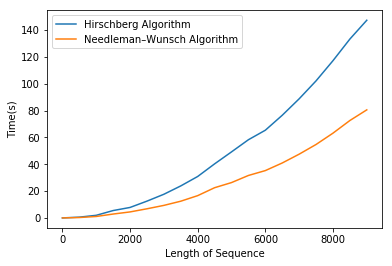

In [73]:
plt.plot(length_number,Hirschberg_time_avg, label = 'Hirschberg Algorithm' )
plt.plot(length_number,Global_time_avg, label = 'Needleman–Wunsch Algorithm' )
plt.xlabel('Length of Sequence')
plt.ylabel('Time(s)')
plt.legend()
plt.savefig('TimeAnalysis.jpg')
plt.show()

# Space Analysis

In [66]:
result_global = np.array(open("result_global.txt", "r").read().split(',')[:-1]).reshape(10 ,19).astype('float')
result_hirschberg = np.array(open("result_hirschberg.txt", "r").read().split(',')[:-1]).reshape(10 ,19).astype('float')

In [70]:
def memory_plot(x, y, fit, fitting_line):
    coefs = poly.polyfit(x, y, fit)
    p = poly.Polynomial(coefs)
    
    plt.plot(x, y, '.', label = 'Memory Usage') 
    plt.plot(x, p(x), '-', label = fitting_line)
    plt.legend()
    
    plt.xlabel('Length of Sequence')
    plt.ylabel('Space(MB)')
    plt.show()

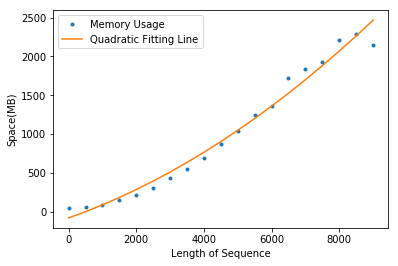

In [77]:
memory_plot(length_of_sequence, result_global.mean(0), 2, "Quadratic Fitting Line")
plt.savefig('GlobalAlignmentSpaceAnalysis.jpg')

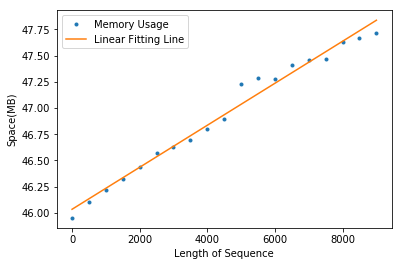

In [78]:
memory_plot(length_of_sequence, result_hirschberg.mean(0), 1, "Linear Fitting Line")
plt.savefig('HirschbergSpaceAnalysis.jpg')